In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolTransforms
import py_rdl
import RA

# Cremer Pople Puckering Parameter

In [2]:
# Five
five = pd.read_csv("five.csv")

In [4]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(five[["A0","A1","A2","A3","A4"]].values):
    if list(item)==["M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_five = five.iloc[monocyclic].reset_index(drop=True)
poly_five = five.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_five[["B0","B1","B2","B3","B4"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [23]:
molecule = Chem.SDMolSupplier("molecule/unique.sdf",removeHs=False)

In [24]:
keep = []
inchis = []
for idx, mol in enumerate(molecule):
    inchi = Chem.MolToInchiKey(mol)
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==7:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                atomtype = RA.GetRingAtomType(mol, ringloop)
                if inchi not in inchis:
                #if all([x=="M" for x in atomtype]) and (inchi not in inchis):
                    inchis.append(inchi)
                    keep.append(mol)

In [25]:
len(keep)

5135

In [8]:
len(keep)

5135

In [26]:
seven = Chem.SDWriter("seven_all.sdf")
for mol in keep:
    seven.write(mol)
seven.close()

In [5]:
molecule = Chem.SDMolSupplier("mono_five.sdf")

In [100]:
result = []
smarts = Chem.MolFromSmarts("[r5]!@-[!#1]")
#dsmarts = Chem.MolFromSmarts("[C;R1](=[O])@[!#1;R1]@[!#1;R1]")
storsions = []
for idx, mol in enumerate(molecule):
    bonds = []
    smatches = mol.GetSubstructMatches(smarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5) ]
                for m in smatches:
                    if m[0] in ringloop:
                        storsions.append((idx,bondtype,atomtype,ringloop.index(m[0]),cptmp[0][0],cptmp[1][0], *RA.GetRingSubstituentPosition(mol, ringloop, [m[0],m[1]])))
                #dtorsions = []
                #for m in dmatches:
                #    dtorsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, dtorsions, storsions))


NameError: name 'molecule' is not defined

In [228]:
t = pd.DataFrame(storsions)

In [229]:
kidx = []
for idx in range(len(t)):
    check1 = [x==1.0 for x in t.iloc[idx,1]]
    check2 = [x=="M" for x in t.iloc[idx,2]]
    if all(check1) and all(check2):
        kidx.append(idx)

In [295]:
fil = t.iloc[kidx,:][t.iloc[kidx,3]==1]

In [359]:
fil1 = fil[fil.iloc[:,6]<0.8]

In [360]:
c1, c2 = fil1.iloc[:,4],fil1.iloc[:,5]
Y = fil1.iloc[:,6]

In [361]:
X = np.column_stack([np.ones(len(c1)), (c1**2)*np.cos(2*c2),(c1**2)*np.sin(2*c2), c1*np.cos(c2), c1*np.sin(c2)])

In [362]:
fil2 = fil[fil.iloc[:,6]>1.5]

In [364]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)
beta = np.matmul(xtx,xty)
xb = np.matmul(X,beta)

In [365]:
beta

array([ 0.61718693,  0.15071282, -0.21828034,  1.01143493,  0.59868938])

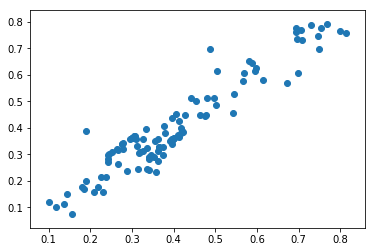

In [366]:
plt.scatter(xb,Y)

In [367]:
np.corrcoef(xb,Y)

array([[1.        , 0.94478294],
       [0.94478294, 1.        ]])

In [270]:
result = []
smarts = Chem.MolFromSmarts("[r5]([!#1])@[r5]@[r5]")
dsmarts = Chem.MolFromSmarts("[C;R1](=[O])@[!#1;R1]@[!#1;R1]")
for idx, mol in enumerate(molecule):
    bonds = []
    smatches = mol.GetSubstructMatches(smarts)
    dmatches = mol.GetSubstructMatches(dsmarts)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==5:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%5,(i+1)%5,(i+2)%5,(i+3)%5]]) for i in range(5) ]
                storsions = []
                for m in smatches:
                    if (m[0] in ringloop) and (m[2] in ringloop) and (m[3] in ringloop):
                        if (ringloop.index(m[0])<ringloop.index(m[2])) and (ringloop.index(m[2])<ringloop.index(m[3])):
                            ni = ringloop.index(m[0])
                            storsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                dtorsions = []
                for m in dmatches:
                    if (m[0] in ringloop) and (m[2] in ringloop) and (m[3] in ringloop):
                        if (ringloop.index(m[0])<ringloop.index(m[2])) and (ringloop.index(m[2])<ringloop.index(m[3])):
                            ni = ringloop.index(m[0])
                            dtorsions.append([(ni, rdMolTransforms.GetDihedralRad(mol.GetConformer(),m[1], ringloop[ni],ringloop[(ni+1)%5],ringloop[(ni+2)%5]))])
                #tmp =[]
                #for m in match:
                #    if (m[0] in ringloop) and (m[1] in ringloop) and (m[2] in ringloop) and (ringloop.index(m[2])>ringloop.index(m[1])):
                #         tmp.append((ringloop.index(m[2]), rdMolTransforms.GetDihedralRad(mol.GetConformer(), *m)))
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion, dtorsions, storsions))


KeyboardInterrupt: 

In [ ]:
dtorsions

In [183]:
f = pd.DataFrame(result)

In [184]:
si = []
for idx, item in enumerate(f.iloc[:,8:13].values):
    check = [x=="M" for x in item]
    if all(check):
        si.append(idx)

g = f.iloc[si,:].reset_index(drop=True)
gi = []
for idx, item in enumerate(g.iloc[:,3:8].values):
    check = [x==1.0 for x in item]
    if all(check):
        gi.append(idx)
final = g.iloc[gi,:].reset_index(drop=True)

In [185]:
f1,f2,f3 = np.ones(len(final)), final.iloc[:,1]*np.cos(final.iloc[:,2]).values,final.iloc[:,1]*np.sin(final.iloc[:,2]).values
X = np.column_stack([f1,f2,f3])
Y = final.iloc[:,13].values

In [186]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)
beta = np.matmul(xtx,xty)

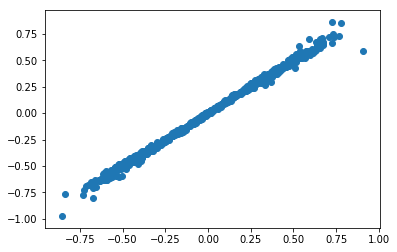

In [187]:
plt.scatter(np.matmul(X,beta),Y)

In [192]:
qi = []
for idx, item in enumerate(final.iloc[:,19].values):
    for x in item:
        if x[0][0]==1:
            qi.append((final.iloc[idx,0],x[0][1],*final.iloc[idx,13:18].values.tolist()))
            
    

In [17]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [18]:
qq = b.iloc[k0,:].reset_index(drop=True)

In [19]:
qqcp = qq.iloc[:,1:3]
qqt = qq.iloc[:,13:18]

In [20]:
Y = qqt.iloc[:,0]
X1 = np.array(qqcp.iloc[:,0]*np.cos(qqcp.iloc[:,1]))
X2 = np.array(qqcp.iloc[:,0]*np.sin(qqcp.iloc[:,1])) 

In [21]:
X = np.array([np.ones(len(X1)),X1,X2]).transpose()

In [22]:
xtx = np.linalg.inv(np.matmul(np.transpose(X),X))
xty = np.matmul(np.transpose(X),Y)

r = np.matmul(xtx,xty)

In [23]:
r

array([-7.67584045e-04,  1.06556925e+00,  1.45228565e+00])

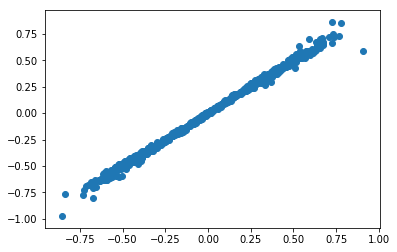

In [24]:
plt.scatter(np.matmul(X,np.transpose(np.matmul(xtx,xty))),Y)

In [25]:
Y2 = np.matmul(X,np.transpose(np.matmul(xtx,xty)))

In [26]:
k = []
w = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            k.append(idx)
            w.append(x[1])

In [329]:
def EnumerateRingBond(mol, idxlist):
    """
    Enumerate bonds in a cycle

    Input:

    mol: rdMol

    idxlist: list (ring atoms)

    Return:

    ringbond: list of tuples [(atom_1, atom_2)]
    
    """
    ringbond = []
    size = len(idxlist)
    ringbond = [(idxlist[i%size],idxlist[(i+1)%size]) for i in range(size)]
    return ringbond

In [ ]:
def GetShareSingleBondAtomsInRing(mol):
    """
    Identify single bond shared by multiple ring systems

    Return:

    """
    edgelist = []
    for bond in mol.GetBonds():
        edgelist.append((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))
    data = py_rdl.Calculator.get_calculated_result(edgelist)
    rings = []
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            rcs = data.get_relevant_cycles_for_urf(urf)
            ringatoms = Rearrangement(mol,list(rc.nodes))
            rings.append([str(rc.urf),ringatoms])
    NumRCs = len(rings)
    # identify the atoms/single bonds that share in fused ring
    bridgehead_atoms = []
    bridgehead_set = list(set(bridgehead_atoms))
    # Check for Fused Ring/Bridge Ring Atoms
    for i in itertools.combinations(range(NumRCs),2):
        if rings[i[0]][0]!=rings[i[1]][0]:  # only consider unpaired URFs
            bondsetA = EnumerateRingBond(mol,rings[i[0]][1])
            bondsetB = EnumerateRingBond(mol,rings[i[1]][1])
            sorted_bondsetA = [tuple(sorted(ebond)) for ebond in bondsetA]
            sorted_bondsetB = [tuple(sorted(ebond)) for ebond in bondsetB]
            intersections = list(set(sorted_bondsetA).intersection(sorted_bondsetB))
            intersectionelement = [x for bondpair in intersections for x in bondpair]
            if any(intersections):
                if len(intersections)>1:
                    bridgering_element = list(set(intersectionelement))
                    for node in bridgering_element:
                        if intersectionelement.count(node)==1:
                            bridgehead_atoms.append(node)
            ringsintersection = list(set(rings[i[0]][1]).intersection(set(rings[i[1]][1])))
            if len(ringsintersection)==1:
                spiro_atoms.append(ringsintersection[0])
    bridgehead_set = list(set(bridgehead_atoms))
    return bridgehead_set



# Seven-membered Ring 

In [32]:
seven = Chem.SDMolSupplier("seven_all.sdf")

In [76]:
result1 = []
smarts_1 = Chem.MolFromSmarts("[R][O;R][C;R](=O)")
for idx, mol in enumerate(seven):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==7:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check1 = [mat[0] in ringloop for mat in mat1]
                result1.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype, any(check1)))


In [33]:
result = []
smarts_1 = Chem.MolFromSmarts("[C;R](=O)[O,N;R]")
smarts_2 = Chem.MolFromSmarts("[R]1@[R]@[R]1")
smarts_3 = Chem.MolFromSmarts("[O;R][C,S;R][O;R]")
smarts_4 = Chem.MolFromSmarts("[S;R][S;R]")
smarts_5 = Chem.MolFromSmarts("[P,Si;R]")
smarts_6 = Chem.MolFromSmarts("[R][O;R][C;R](=O)")
for idx, mol in enumerate(seven):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    mat2 = mol.GetSubstructMatches(smarts_2)
    mat3 = mol.GetSubstructMatches(smarts_3)
    mat4 = mol.GetSubstructMatches(smarts_4)
    mat5 = mol.GetSubstructMatches(smarts_5)
    mat6 = mol.GetSubstructMatches(smarts_6)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==7:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check1 = [set(ringloop).intersection(set(mat)) for mat in mat1]
                check2 = [set(ringloop).intersection(set(mat)) for mat in mat2]
                check3 = [set(ringloop).intersection(set(mat)) for mat in mat3]
                check4 = [set(ringloop).intersection(set(mat)) for mat in mat4]
                check5 = [set(ringloop).intersection(set(mat)) for mat in mat5]
                check6 = [set(ringloop).intersection(set(mat)) for mat in mat6]
                check7 = [mat[0] in ringloop for mat in mat7]
                check8 = [mat[0] in ringloop for mat in mat8]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype, any(check1), any(check2), any(check3),
                               any(check4),any(check5), any(check6)))


In [4]:
seven_frame = pd.DataFrame(result)
mono = []
poly = []
for idx in range(5686):
    check1 = [x==1.0 for x in seven_frame.iloc[idx,5:12].values]
    check2 = [x=="M" for x in seven_frame.iloc[idx,12:19].values]
    if all(check1) and all(check2):
        mono.append(idx)
    elif all(check1) and not all(check2):
        poly.append(idx)
    else:
        continue

In [35]:
alls = mono+poly

In [43]:
unconstrained_seven = seven_frame.iloc[alls,:]
stf = unconstrained_seven.iloc[:,19:26].sum(axis=1)==0
filtered_seven = unconstrained_seven[stf]

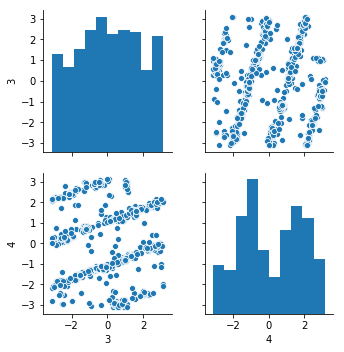

In [38]:
sns.pairplot(seven_frame.iloc[alls,:][seven_frame.iloc[alls,19:25].sum(axis=1)==0].iloc[:,3:5])

In [7]:
a = seven_frame.iloc[alls,:][seven_frame.iloc[alls,19:].values.sum(axis=1)==0]

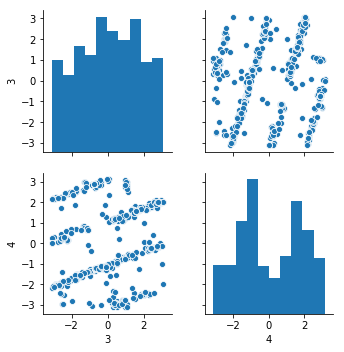

In [8]:
sns.pairplot(a.iloc[:,3:5])

In [9]:
a = seven_frame.iloc[poly]

In [10]:
x = np.arange(-np.pi,np.pi,0.02)
y1 = -np.pi+x/3
y2 = -np.pi/3+x/3
y3 = np.pi/3+x/3
y4 = np.pi+x/3

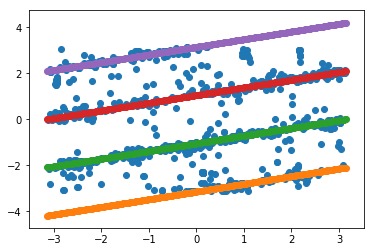

In [11]:
plt.scatter(a.iloc[:,3],a.iloc[:,4])
plt.scatter(x,y1)
plt.scatter(x,y2)
plt.scatter(x,y3)
plt.scatter(x,y4)

In [54]:
a = a.reset_index(drop=True)
t = pd.concat([a.iloc[:,4]-(a.iloc[:,3]/3-np.pi),a.iloc[:,4]-(a.iloc[:,3]/3-np.pi/3),a.iloc[:,4]-(a.iloc[:,3]/3+np.pi/3),a.iloc[:,4]-(a.iloc[:,3]/3+np.pi)],axis=1)
b = a[(np.abs(t)<0.5).apply(any,axis=1)]

In [55]:
notin = [i for i in range(1222) if i not in b.index ]

In [98]:
x1 = np.array([-np.pi/3,np.pi/3])
y1a = 3*x1
y1b = np.pi/3+x1

x2 = np.array([-np.pi/3,0])
y2a = 3*x2
y2b = np.pi+x2

x3 = np.array([-np.pi/3,np.pi/3])
y3a = 3*x1
y3b = -np.pi/3+x1

x4 = np.array([0,np.pi/3])
y4a = 3*x4
y4b = -np.pi+x4



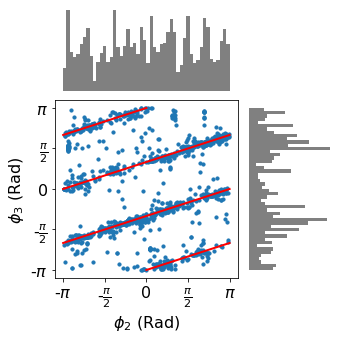

In [101]:
fig = plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.1, hspace=0.1)
x,y, = np.linspace(-np.pi,np.pi,100),np.linspace(-np.pi,np.pi,100)
X,Y  = np.meshgrid(x,y)
ax0_joint = fig.add_subplot(gs[1:3,0:2])
ax0_marg_x = fig.add_subplot(gs[0,0:2])
ax0_marg_y = fig.add_subplot(gs[1:3,2])

ax0_joint.scatter(unconstrained_seven.iloc[:,3],unconstrained_seven.iloc[:,4],s=10)
ax0_joint.plot(y1a,y1b,color="red",lw=2)
ax0_joint.plot(y2a,y2b,color="red",lw=2)
ax0_joint.plot(y3a,y3b,color="red",lw=2)
ax0_joint.plot(y4a,y4b,color="red",lw=2)
ax0_marg_x.hist(unconstrained_seven.iloc[:,3], bins=50, color="grey")
ax0_marg_y.hist(unconstrained_seven.iloc[:,4],orientation="horizontal", bins=50, color="grey")
ax0_marg_x.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_y.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_x.set_axis_off()
ax0_marg_y.set_axis_off()
ax0_joint.set_xlabel(r"$\phi_{2}$ (Rad)", fontsize=16)
ax0_joint.set_ylabel(r"$\phi_{3}$ (Rad)", fontsize=16)
ax0_joint.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_xticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
ax0_joint.set_yticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
plt.savefig("Fig/Macrocycle/seven_phis_all.pdf",dpi=150, bbox_inches="tight")
plt.show()


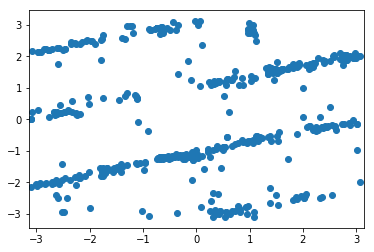

In [524]:
x1 = np.arange(-np.pi,np.pi,0.02)
y1a = np.mod(3*x1,np.pi*2)-np.pi
y1b = np.mod(3*x1+3*np.pi/7,np.pi*2)-np.pi
y2a = np.mod(x1+np.pi,np.pi*2)-np.pi
y2b = np.mod(x1+np.pi+np.pi/7,np.pi*2)-np.pi
#plt.scatter(y1a,y2a)
plt.xlim(-np.pi,np.pi)
plt.scatter(b.iloc[:,3],b.iloc[:,4])
plt.show()
#plt.scatter(b.iloc[:,3],b.iloc[:,4])

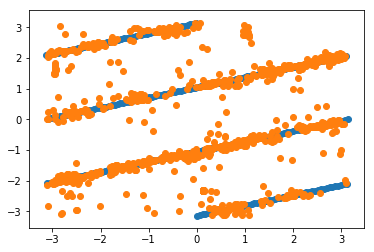

In [267]:
x1 = np.arange(-np.pi,np.pi,0.02)
y1a = np.mod(3*x1,np.pi*2)-np.pi
y1b = np.mod(3*x1+3*np.pi/7,np.pi*2)-np.pi
y2a = np.mod(x1+np.pi,np.pi*2)-np.pi
y2b = np.mod(x1+np.pi+np.pi/7,np.pi*2)-np.pi
plt.scatter(y1a,y2a)
#plt.scatter(y1b,y2b)
plt.scatter(b.iloc[:,3],b.iloc[:,4])
#plt.scatter(y2a,y2b)

# Eight-membered Ring

In [102]:
eight = Chem.SDMolSupplier("eight_all.sdf")

In [103]:
result = []
smarts_1 = Chem.MolFromSmarts("[C;R](=O)[O,N;R]") 
smarts_2 = Chem.MolFromSmarts("[Si;R][O;R]")
for idx, mol in enumerate(eight):
    bonds = []
    mat1 = mol.GetSubstructMatches(smarts_1)
    mat2 = mol.GetSubstructMatches(smarts_2)
    mat3 = mol.GetSubstructMatches(smarts_3)
    mat4 = mol.GetSubstructMatches(smarts_4)
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==8:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                ringatom = [item[1] for item in RA.GetRingElement(mol, ringloop)]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                check1 = [set(ringloop).intersection(set(mat)) for mat in mat1]
                check2 = [set(ringloop).intersection(set(mat)) for mat in mat2]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype, *ringatom, any(check1),any(check2)))


In [104]:
eight_frame = pd.DataFrame(result)
mono = []
poly = []
for idx in range(1007):
    check1 = [x==1.0 for x in eight_frame.iloc[idx,6:14].values]
    check2 = [x=="M" for x in eight_frame.iloc[idx,14:22].values]
    if all(check1) and all(check2):
        mono.append(idx)
    elif all(check1) and not all(check2):
        poly.append(idx)
    else:
        continue

In [105]:
alls = mono+poly

In [114]:
sel = eight_frame.iloc[alls,:][eight_frame.iloc[alls,30:32].values.sum(axis=1)==0]

In [115]:
x1 = np.array([-np.pi/2,np.pi/2])
y1a = 2*x1
y1b = np.pi/2+x1

x2 = np.array([-np.pi/2,0])
y2a = 2*x2
y2b = np.pi+x2

x3 = np.array([-np.pi/2,np.pi/2])
y3a = 2*x1
y3b = -np.pi/2+x1

x4 = np.array([-np.pi/2,np.pi/2])
y4a = 2*x4
y4b = x4

x5 = np.array([0,np.pi/2])
y5a = 2*x5
y5b = -np.pi+x5

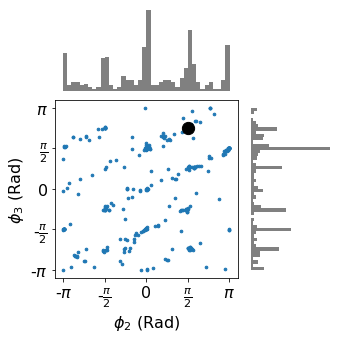

In [119]:
fig = plt.figure(figsize=(5,5))
gs = gridspec.GridSpec(nrows=3, ncols=3, wspace=0.1, hspace=0.1)
x,y, = np.linspace(-np.pi,np.pi,100),np.linspace(-np.pi,np.pi,100)
X,Y  = np.meshgrid(x,y)
ax0_joint = fig.add_subplot(gs[1:3,0:2])
ax0_marg_x = fig.add_subplot(gs[0,0:2])
ax0_marg_y = fig.add_subplot(gs[1:3,2])

ax0_joint.scatter(sel.iloc[:,4],sel.iloc[:,5],s=7)
#ax0_joint.plot(y1a,y1b,lw=2, color="red")
#ax0_joint.plot(y2a,y2b,lw=2, color="red")
#ax0_joint.plot(y3a,y3b,lw=2, color="red")
#ax0_joint.plot(y4a,y4b,lw=2, color="red")
#ax0_joint.plot(y5a,y5b,lw=2, color="red")
ax0_joint.scatter(sel.iloc[30,4],sel.iloc[30,5], color="black", s=150)
ax0_marg_x.hist(sel.iloc[:,4], bins=40, color="grey")
ax0_marg_y.hist(sel.iloc[:,5],orientation="horizontal", bins=50, color="grey")
ax0_marg_x.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_y.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_marg_x.set_axis_off()
ax0_marg_y.set_axis_off()
ax0_joint.set_xlabel(r"$\phi_{2}$ (Rad)", fontsize=16)
ax0_joint.set_ylabel(r"$\phi_{3}$ (Rad)", fontsize=16)
ax0_joint.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax0_joint.set_xticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
ax0_joint.set_yticklabels([r"-$\pi$", r"-$\frac{\pi}{2}$", 0, r"$\frac{\pi}{2}$", r"$\pi$"], fontsize=16)
#plt.savefig("Fig/Macrocycle/eight_phis.pdf",dpi=150, bbox_inches="tight")
plt.show()

(array([13.,  4.,  3.,  2.,  3.,  3.,  8., 17., 12., 12.,  5.,  2.,  3.,
         5., 52., 61.,  6.,  8.,  3.,  7.,  7.,  6., 43., 11.,  4.,  2.,
         2.,  1.,  8.,  8.]),
 array([1.24950397e-04, 1.04439034e-01, 2.08753118e-01, 3.13067201e-01,
        4.17381285e-01, 5.21695369e-01, 6.26009452e-01, 7.30323536e-01,
        8.34637620e-01, 9.38951703e-01, 1.04326579e+00, 1.14757987e+00,
        1.25189395e+00, 1.35620804e+00, 1.46052212e+00, 1.56483621e+00,
        1.66915029e+00, 1.77346437e+00, 1.87777846e+00, 1.98209254e+00,
        2.08640662e+00, 2.19072071e+00, 2.29503479e+00, 2.39934887e+00,
        2.50366296e+00, 2.60797704e+00, 2.71229113e+00, 2.81660521e+00,
        2.92091929e+00, 3.02523338e+00, 3.12954746e+00]),
 <a list of 30 Patch objects>)

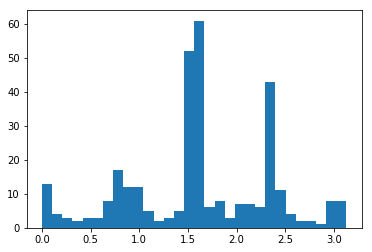

In [123]:
plt.hist(np.mod(sel.iloc[:,4]-sel.iloc[:,5],np.pi),bins=30)

In [134]:
x = np.arange(-np.pi,np.pi,0.05)
y = x+np.random.uniform(-0.01,0.01)

In [136]:

sel.iloc[30,4],sel.iloc[30,5]


(1.5894701365441688, 2.3562830576963867)

0.7480282325319081

In [8]:
len(alls)

455

In [9]:
len(sel)

317

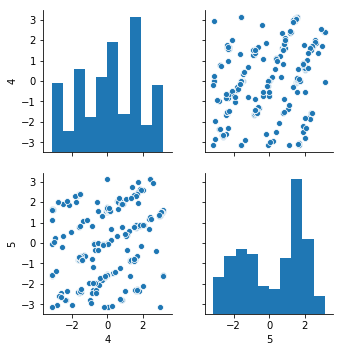

In [58]:
sns.pairplot(sel.iloc[:,4:6])

In [59]:
x = np.arange(-np.pi,np.pi,0.02)
y1 = -np.pi/2+x/2
y2 = x/2
y3 = np.pi+x/2
y4 = np.pi/2+x/2
y5 = -np.pi+x/2

In [60]:
sel = sel.reset_index(drop=True)
t1 = pd.concat([sel.iloc[:,4]-(sel.iloc[:,3]/2-np.pi/2),
                sel.iloc[:,4]-(sel.iloc[:,3]/2-np.pi),
                sel.iloc[:,4]-(sel.iloc[:,3]/2+np.pi/2),
                sel.iloc[:,4]-(sel.iloc[:,3]/2+np.pi),
               sel.iloc[:,4]-(sel.iloc[:,3]/2)],axis=1)

In [89]:
b = sel[(np.abs(t1)<0.7).apply(any,axis=1)]

In [90]:
len(b)

303

In [91]:
len(alls)

455

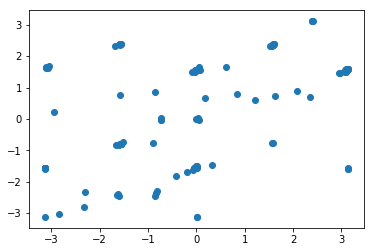

In [120]:
plt.scatter(sel.iloc[:,4],sel.iloc[:,5])
# plt.scatter(x,y1)
# plt.scatter(x,y2)
# plt.scatter(x,y3)
# plt.scatter(x,y4)
# plt.scatter(x,y5)
plt.show()

In [119]:
b[(b.iloc[:,4]<0.5) & (b.iloc[:,4]>-0)  & (b.iloc[:,5]>-0.5)  & (b.iloc[:,5]<)]

SyntaxError: invalid syntax (<ipython-input-119-c27b21ddcccb>, line 1)

(array([10.,  2.,  0.,  2.,  1.,  8.,  9., 12.,  3.,  2.,  2., 11., 41.,
         3.,  4.,  4.,  3.,  4., 16.,  4.,  0.,  0.,  0.,  2.,  3.,  3.,
         2.,  1.,  2.,  2.,  3., 13.,  2.,  1.,  0.,  0.,  4., 45., 16.,
         4.,  0.,  2.,  1., 25., 12.,  4.,  2.,  1.,  7.,  5.]),
 array([1.24950397e-04, 1.25545254e-01, 2.50965557e-01, 3.76385860e-01,
        5.01806163e-01, 6.27226467e-01, 7.52646770e-01, 8.78067073e-01,
        1.00348738e+00, 1.12890768e+00, 1.25432798e+00, 1.37974829e+00,
        1.50516859e+00, 1.63058889e+00, 1.75600920e+00, 1.88142950e+00,
        2.00684980e+00, 2.13227011e+00, 2.25769041e+00, 2.38311071e+00,
        2.50853102e+00, 2.63395132e+00, 2.75937162e+00, 2.88479193e+00,
        3.01021223e+00, 3.13563253e+00, 3.26105284e+00, 3.38647314e+00,
        3.51189344e+00, 3.63731374e+00, 3.76273405e+00, 3.88815435e+00,
        4.01357465e+00, 4.13899496e+00, 4.26441526e+00, 4.38983556e+00,
        4.51525587e+00, 4.64067617e+00, 4.76609647e+00, 4.89151678e+

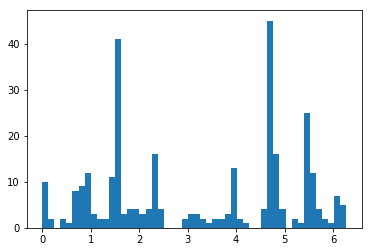

In [99]:
plt.hist(np.mod(b.iloc[:,4]-b.iloc[:,5],2*np.pi),bins=50)

In [494]:
b.index

Int64Index([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            306, 307, 308, 309, 310, 311, 313, 314, 315, 316],
           dtype='int64', length=292)

In [495]:
notin = [x for x in range(317) if x not in b.index]

In [496]:
sum(sel.iloc[notin,-1])

11

In [497]:
len(notin)

25

In [499]:
sel.iloc[notin,:]

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
2,22,1.030972,0.606745,-0.354678,-1.561143,-0.786009,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,True
11,85,1.029861,0.604945,-0.346062,-3.051039,1.670560,1.0,1.0,1.0,1.0,...,6,6,8,6,6,6,False,False,False,True
13,100,1.017723,0.616109,0.355868,-0.078564,-1.613239,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False
14,102,0.460122,0.000160,0.807551,-0.865011,0.847788,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,True
20,152,1.036046,0.613874,-0.356977,3.139140,-1.594516,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False
25,184,1.058369,0.593838,0.332129,-1.606773,-2.454773,1.0,1.0,1.0,1.0,...,6,6,6,6,6,8,False,False,False,False
30,259,1.032222,0.610774,0.357816,1.589470,2.356283,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False
32,336,1.034376,0.603652,0.368392,-0.051981,-1.579348,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False
76,557,1.037183,0.615648,0.347393,-3.140297,-3.140829,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False
80,564,1.039493,0.610687,0.357032,1.531145,2.312770,1.0,1.0,1.0,1.0,...,6,6,6,6,6,6,False,False,False,False


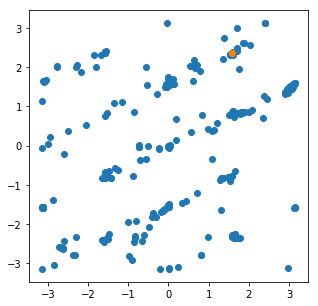

In [104]:
fig = plt.figure(figsize=(5,5))
plt.scatter(b.iloc[:,4],b.iloc[:,5])
plt.scatter(sel.iloc[30,4],sel.iloc[30,5])

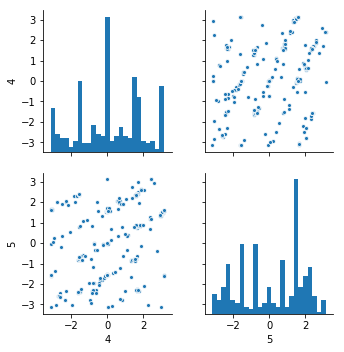

In [120]:
sns.pairplot(sele[sele.iloc[:,30:].values.sum(axis=1)==0].iloc[:,4:6],plot_kws=dict(s=15),diag_kws=dict(bins=25))

In [88]:
mono_8 = mono_eight[mono_eight.iloc[:,30:].values.sum(axis=1)==0]
poly_8 = poly_eight[poly_eight.iloc[:,30:].values.sum(axis=1)==0]

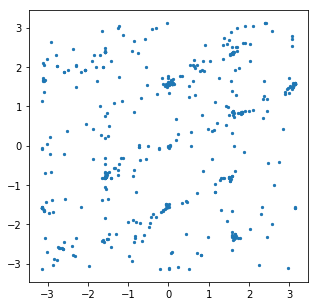

In [116]:
plt.figure(figsize=(5,5))
plt.scatter(sele.iloc[:,4],sele.iloc[:,5],s=5)
#plt.scatter(mono_8.iloc[:,4],mono_8.iloc[:,5])
#plt.scatter(poly_8.iloc[:,4],poly_8.iloc[:,5])

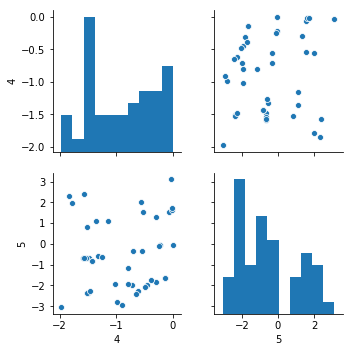

In [58]:
sns.pairplot(poly_8[(poly_8.iloc[:,4]<0) &  (poly_8.iloc[:,4]>-2)].iloc[:,4:6])

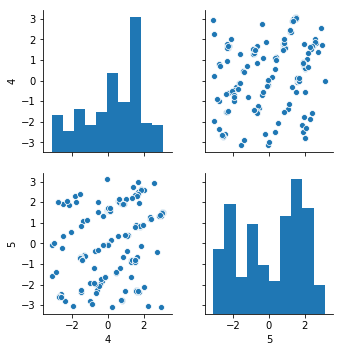

In [64]:
sns.pairplot(poly_8.iloc[:,4:6])

In [71]:
poly_8[(poly_8.iloc[:,4]<0) & (poly_8.iloc[:,4]>-2) & (poly_8.iloc[:,5]<-1.5)]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
70,50,0.058795,0.003681,-0.803640,-0.613120,-2.281065,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
142,108,0.920167,0.715456,0.299042,-0.303031,-1.810862,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
277,212,1.004876,0.667724,0.349975,-0.136678,-1.654936,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
333,257,0.508145,0.920836,0.122587,-1.013852,-1.939134,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
348,270,1.044641,0.624251,0.372919,-1.519181,-2.365017,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
370,286,1.042494,0.629072,0.376570,-1.503808,-2.368944,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
385,298,1.045029,0.623431,0.372479,-1.519941,-2.364112,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
439,343,1.628814,0.000129,0.078772,-0.987732,-2.805796,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
506,393,0.691870,0.794388,0.276225,-0.450885,-1.962391,1.0,1.0,1.0,1.0,...,6,6,6,7,6,False,False,False,False,False
515,402,0.056743,0.010965,-0.804629,-0.655245,-2.419810,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False


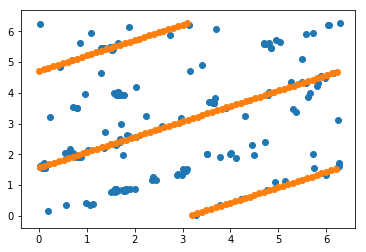

In [78]:
plt.scatter(np.mod(poly_8.iloc[:,4],2*np.pi),np.mod(poly_8.iloc[:,5],2*np.pi))
plt.scatter(y1,y2)
#plt.scatter(y3,y4)

In [84]:
poly_8[(np.mod(poly_8.iloc[:,4],2*np.pi)>5) & (np.mod(poly_8.iloc[:,5],2*np.pi)>2.5) & (np.mod(poly_8.iloc[:,5],2*np.pi)<4)]

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
439,343,1.628814,0.000129,0.078772,-0.987732,-2.805796,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
515,402,0.056743,0.010965,-0.804629,-0.655245,-2.419810,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
822,682,0.981228,0.603214,-0.364158,-0.039856,3.125551,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False
956,815,0.515437,0.098347,0.813020,-0.905404,-2.919638,1.0,1.0,1.0,1.0,...,6,6,6,6,6,False,False,False,False,False


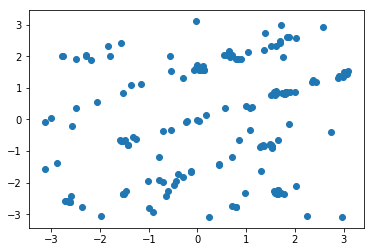

In [79]:
plt.scatter(poly_8.iloc[:,4],poly_8.iloc[:,5])

In [349]:
remove = [4,32,56,60, 467, 512, 513, 5,10,24,28,31.41,51,55, 27,73,78,109,166,167,187,296,337,339,342,343,347,368,391,491,171,407,478, 23,832,862,789,785,747,748,749]

In [350]:
k = []
for idx, item in enumerate(qq[0].values):
    if item not in remove:
        k.append(idx)

In [76]:
x = np.arange(-np.pi,np.pi,0.05)
y1 = np.mod(2*x,2*np.pi)
y2 = np.mod(x+np.pi/2,np.pi*2)
y3 = np.mod(2*x+np.pi/2,np.pi*2)
y4 = np.mod(x+np.pi*135/180,np.pi*2)

In [374]:
qq.iloc[k].iloc[50:90]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
408,321,0.767415,0.859857,-0.251649,-2.286794,2.012792,1.0,1.0,1.0,1.0,...,1.0,1.0,M,B,P,B,M,M,M,M
411,324,0.977042,0.588956,0.335027,1.030333,2.139187,1.0,1.0,1.0,1.0,...,1.0,1.0,B,B,M,B,B,B,M,M
414,327,1.035493,0.647819,-0.320790,0.183754,0.153779,1.0,1.0,1.0,1.0,...,1.0,1.0,M,B,B,M,M,M,M,M
420,333,0.527716,0.432651,0.399212,-2.938809,-0.216152,1.0,1.0,1.0,1.0,...,1.0,1.0,B,M,M,M,M,M,B,B
422,335,1.027531,0.629151,0.368446,1.656888,-0.652552,1.0,1.0,1.0,1.0,...,1.0,1.0,B,P,B,M,M,M,M,M
440,344,1.019909,0.606932,0.348710,-0.066193,1.558436,1.0,1.0,1.0,1.0,...,1.0,1.0,B,B,M,M,M,M,M,M
452,352,1.553408,0.025258,0.018507,2.980125,1.336102,1.0,1.0,1.0,1.0,...,1.0,1.0,M,M,M,B,B,M,M,M
453,353,0.000214,0.890176,0.000066,-1.789448,1.992030,1.0,1.0,1.0,1.0,...,1.0,1.0,B,B,M,M,B,B,M,M
465,362,0.926703,0.001226,0.000990,-1.568315,-1.837461,1.0,1.0,1.0,1.0,...,1.0,1.0,M,M,B,M,M,M,B,M
480,372,1.000401,0.510248,0.420666,1.290370,-0.880419,1.0,1.0,1.0,1.0,...,1.0,1.0,B,B,M,M,B,P,B,B


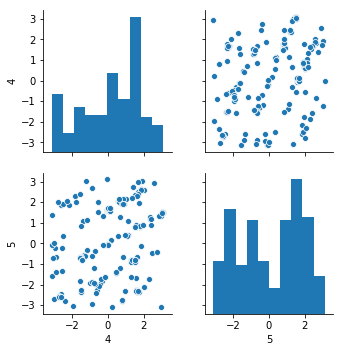

In [362]:
sns.pairplot(qq.iloc[k,4:6])

In [268]:
y3 = 1.06556925*qq.iloc[k,1]*np.cos(qq.iloc[k,2]+4*np.pi/5) + 1.45228565*qq.iloc[k,1]*np.sin(qq.iloc[k,2]+4*np.pi/5) -0.000767584
#y3 = 1.06652924*qq.iloc[k,1]*np.cos(qq.iloc[k,2]) + 1.46343720*qq.iloc[k,1]*np.sin(qq.iloc[k,2]) + 2.45539702e-04

In [315]:
e = np.column_stack([np.ones(len(y3)),y3])

In [316]:
xtx2 = np.linalg.inv(np.matmul(np.transpose(e),e))
xty = np.matmul(np.transpose(e),w)
r=  np.matmul(xtx2,xty)

In [281]:
keep = []
for idx, item in enumerate(qq.iloc[:,18].values):
    for x in item:
        if x[0]==1:
            keep.append((idx,*qq.iloc[idx,[1,2]].values.tolist(),x[1]))
    

In [282]:
w = pd.DataFrame(keep)

In [109]:
w1 = -7.67584045e-04 + 1.06556925*w.iloc[:,1]*np.cos(w.iloc[:,2]+4*np.pi/5) + 1.45228565*w.iloc[:,1]*np.sin(w.iloc[:,2]+4*np.pi/5)

In [110]:
w2 = np.array([np.ones(len(w1)),w1.values]).transpose()

In [111]:
y1 = w.iloc[:,3].values

In [115]:
xtx = np.linalg.inv(np.matmul(np.transpose(w2),w2))
xty = np.matmul(np.transpose(w2),y1)

np.matmul(xtx,xty)

array([ 0.0483072 , -0.13607817])

In [119]:
r =  0.0483072-0.1361*w2

In [258]:
result = []
for idx, mol in enumerate(peptide):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if len(list(rc.nodes))==12:
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ccoord = RA.Translate(coord)
                cptmp = RA.GetRingPuckerCoords(ccoord)
                bond = RA.GetRingBonds(mol, ringloop)
                bondtype = [item[1] for item in bond]
                atomtype = RA.GetRingAtomType(mol, ringloop)
                torsion = [rdMolTransforms.GetDihedralRad(mol.GetConformer(),*[ringloop[x] for x in [i%12,(i+1)%12,(i+2)%12,(i+3)%12]]) for i in range(12) ]
                result.append((idx,*cptmp[0],*cptmp[1],*bondtype,*atomtype,*torsion))


In [282]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,22:34].values):
    if list(i)==["M","M","M","M","M","M","M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

In [292]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,10:22].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [416]:
pep = pd.read_csv("data/cyclic_peptide_2.csv")

In [500]:
cc1 = []
cc2 = []
for idx, item in enumerate(pep[["P1","P2","P3","P4"]].values):
    if list(item)==["C","C","C","C"]:
        cc1.append(idx)
    elif list(item) in [["C","C","C","T"],["C","T","C","C"],["C","C","T","C"]]:
        cc2.append(idx)

In [ ]:
k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

In [67]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,8:13].values):
    if list(i)==["M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,3:7].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

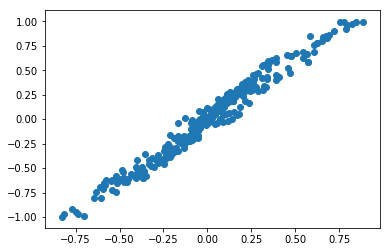

In [45]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]) + a.iloc[k0,1]*np.sin(a.iloc[k0,2])
t2 = a.iloc[k0,13]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+4*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+4*np.pi/5)
t2 = a.iloc[k0,14]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+8*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+8*np.pi/5)
t2 = a.iloc[k0,15]
plt.scatter(t1,t2)

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+12*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+12*np.pi/5)
t2 = a.iloc[k0,16]
plt.scatter(t1,t2)
plt.show()

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,2]+16*np.pi/5) + a.iloc[k0,1]*np.sin(a.iloc[k0,2]+16*np.pi/5)
t2 = a.iloc[k0,17]
plt.scatter(t1,t2)
plt.show()

In [184]:
a = pd.DataFrame(result)

k = []
for idx, i in enumerate(a.iloc[:,10:16].values):
    if list(i)==["M","M","M","M","M","M"]:
        k.append(idx)
        
b = a.iloc[k,:].reset_index(drop=True)

k1 = []
k0 = []
for idx, item in enumerate(b.iloc[:,4:10].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        k0.append(idx)
    elif sum(check)==1:
        k1.append(idx)

(array([  5., 481.,  85.,  47.,  13.,  21.,  24.,  54., 223., 317.]),
 array([-1.42534239, -1.16060662, -0.89587084, -0.63113506, -0.36639929,
        -0.10166351,  0.16307226,  0.42780804,  0.69254382,  0.95727959,
         1.22201537]),
 <a list of 10 Patch objects>)

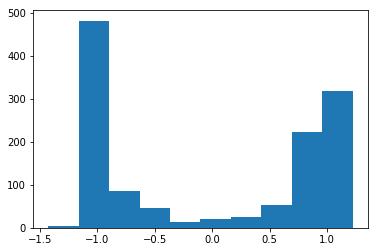

In [185]:
plt.hist(b.iloc[k0,:][16])

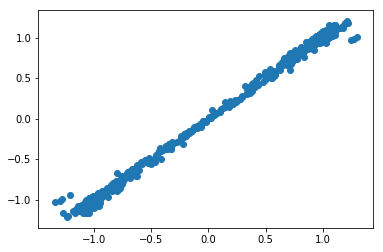

In [247]:
t1 = -0.047*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+4*np.pi/3) + 1.48*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+4*np.pi/3) + 1.74*b.iloc[k0,2]
t2 = b.iloc[k0,18]
plt.scatter(t1,t2)

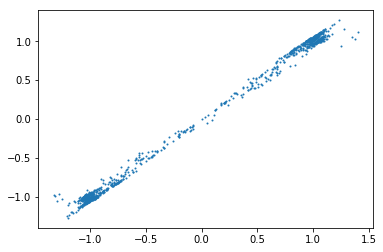

In [256]:
t1 = -0.038*b.iloc[k0,1]*np.cos(b.iloc[k0,3]+6*np.pi/3) + 1.587*b.iloc[k0,1]*np.sin(b.iloc[k0,3]+6*np.pi/3) - 1.78*b.iloc[k0,2]
t2 = b.iloc[k0,19]
plt.scatter(t1,t2,s=1)

In [396]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,36])

In [568]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6])
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6])
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7])
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7])
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8])
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8])
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9])
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9])
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,34])

In [564]:
a1 = b.iloc[k0,1]*np.cos(b.iloc[k0,6]+11*2*np.pi*2/12)
b1 = b.iloc[k0,1]*np.sin(b.iloc[k0,6]+11*2*np.pi*2/12)
c1 = b.iloc[k0,2]*np.cos(b.iloc[k0,7]+11*2*np.pi*3/12)
d1 = b.iloc[k0,2]*np.sin(b.iloc[k0,7]+11*2*np.pi*3/12)
e1 = b.iloc[k0,3]*np.cos(b.iloc[k0,8]+11*2*np.pi*4/12)
f1 = b.iloc[k0,3]*np.sin(b.iloc[k0,8]+11*2*np.pi*4/12)
g1 = b.iloc[k0,4]*np.cos(b.iloc[k0,9]+11*2*np.pi*5/12)
h1 = b.iloc[k0,4]*np.sin(b.iloc[k0,9]+11*2*np.pi*5/12)
i1 = b.iloc[k0,5]
Y = np.array(b.iloc[k0,45])

In [ ]:
t1= a.iloc[k0,1]*np.cos(a.iloc[k0,3]+5*np.pi/12) + a.iloc[k0,2]
t2 = a.iloc[k0,20]
plt.scatter(t1,t2)

In [93]:
def fixzero(x):
    x_ = np.array([0.0]) if np.allclose(0,x, rtol=1e-06, atol=1e-08) else x
    return x_


def GetRingPuckerCoords(displacement,N):
    """
    Compute Ring Pucker Parameters
    
    Input:

    coordinates: array
    
    Return:

    qs: puckering amplitude (q_i>=0 for all i)
    
    angle: angle defined in 0<= phi_i <= 2pi 

    """

    z = displacement
    if N>4 and N<=20: # In our analysis, we fit it to be smaller than 16.
        if (N%2 == 0): # N even
            m = range(2,int((N/2)))
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            q = np.sqrt(qsin**2 + qcos**2)
            amplitude = np.append(q, (1/np.sqrt(N))*np.dot(z,np.cos(np.arange(0,N)*np.pi)).sum()).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
        else: # N odd
            m = range(2,int((N-1)/2)+1)
            cos_component = [np.dot(z,np.cos(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            sin_component = [np.dot(z,np.sin(2*np.pi*k*np.arange(0,N)/N)) for k in m]
            qcos = fixzero(np.sqrt(2/N)*np.array(cos_component))
            qsin = fixzero(-np.sqrt(2/N)*np.array(sin_component))
            amplitude = np.sqrt(qsin**2 + qcos**2).tolist()
            angle = np.arctan2(qsin,qcos).tolist()
    else:
        print("Ring Size is too big or too small")
    return amplitude, angle


In [94]:
GetRingPuckerCoords(dis,6)

([0.4235599999999999, 0.3622790000000001], [-2.5788809999999995])

In [112]:
GetRingPuckerCoords([dis[x%6] for x in range(2,8)],6)

([0.4235599999999998, 0.3622790000000002], [1.6099092047863912])

In [55]:
0.2204751228718341+2.2927990000000005

2.5132741228718345

In [113]:
(1.6099092047863912+2.5788809999999995)/np.pi

1.3333333333333333

In [99]:
2*np.pi/3

2.0943951023931953

In [38]:
np.pi*4/5

2.5132741228718345

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_single][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5","1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5","1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_one][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5])
g1.axes[0,0].set_yticks([0,0.5])
g1.axes[1,0].set_xticks([0,0.5])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_five.iloc[mono_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_five.iloc[poly_two][["q2","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels([r"0",r"0.5",r"1"])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,0].set_xticklabels([r"0",r"0.5",r"1"])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_five.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [63]:
six = pd.read_csv("six.csv")
monocyclic = []
polycyclic = []
for idx, item in enumerate(six[["A0","A1","A2","A3","A4","A5"]].values):
    if list(item)==["M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_six = six.iloc[monocyclic].reset_index(drop=True)
poly_six = six.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_six[["B0","B1","B2","B3","B4","B5"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_single][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_one][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_six.iloc[mono_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_xlim(-1,1)
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_six.iloc[poly_two][["q2","q3","phi2"]],plot_kws=dict(s=10), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[2,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[2,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1])
g1.axes[0,0].set_yticks([0,0.5,1])
g1.axes[1,0].set_xticks([0,0.5,1])
g1.axes[1,0].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,0].set_xticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[1,1].set_yticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_xticks([-1,-0.5,0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[2,1].set_xticklabels([r"0",r"0.5","1"])
g1.axes[2,1].set_xticklabels([r"-1",r"-0.5","0",r"0.5","1"])
g1.axes[2,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[1,2].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_six.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
seven = pd.read_csv("seven.csv")

In [ ]:
monocyclic = []
polycyclic = []
for idx, item in enumerate(seven[["A0","A1","A2","A3","A4","A5","A6"]].values):
    if list(item)==["M","M","M","M","M","M","M"]:
        monocyclic.append(idx)
    else:
        polycyclic.append(idx)
        
mono_seven = seven.iloc[monocyclic].reset_index(drop=True)
poly_seven = seven.iloc[polycyclic].reset_index(drop=True)

mono_single = []
mono_one = []
mono_two = []
for idx, item in enumerate(mono_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in item]
    if sum(check)==0:
        mono_single.append(idx)
    elif sum(check)==1:
        mono_one.append(idx)
    else:
        mono_two.append(idx)

poly_single = []
poly_one = []
poly_two = []
for idx, item in enumerate(poly_seven[["B0","B1","B2","B3","B4","B5","B6"]].values):
    check = [x==1.5 or x==2.0 for x in list(item)]
    if sum(check)==0:
        poly_single.append(idx)
    elif sum(check)==1:
        poly_one.append(idx)
    else:
        poly_two.append(idx)

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_single][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_single_seven.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=10))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_one][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=30))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_one_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(mono_seven.iloc[mono_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=20))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/mono_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(poly_seven.iloc[poly_two][["q2","q3","phi2","phi3"]],plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{2}$",size=15, rotation=0)
g1.axes[1,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[2,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,0].set_ylabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[3,0].set_xlabel(r"$q_{2}$",rotation=0,size=15)
g1.axes[3,1].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[3,2].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[3,3].set_xlabel(r"$\phi_{3}$",rotation=0,size=15)
g1.axes[0,0].set_xticks([0,0.5,1,1.5])
g1.axes[0,0].set_yticks([0,0.5,1,1.5])
g1.axes[1,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,0].set_yticks([0,0.5,1])
g1.axes[2,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,0].set_xticks([0,0.5,1,1.5])
g1.axes[3,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,0].set_xticks([0,0.5,1,1.5])
g1.axes[1,1].set_xticks([0,0.5,1])
g1.axes[1,1].set_yticks([0,0.5,1])
g1.axes[2,1].set_xticks([0,0.5,1])
g1.axes[2,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[2,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,1].set_xticks([0,0.5,1])
g1.axes[3,1].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,2].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[3,3].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[0,0].set_yticklabels(["0","0.5","1.0","1.5"])
g1.axes[1,0].set_yticklabels(["0","0.5","1.0"])
g1.axes[2,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,0].set_xticklabels(["0","0.5","1","1.5"])
g1.axes[3,1].set_xticklabels(["0","0.5","1"])
g1.axes[3,2].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[3,3].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
g1.axes[0,2].set_visible(False)
g1.axes[0,3].set_visible(False)
g1.axes[1,2].set_visible(False)
g1.axes[1,3].set_visible(False)
g1.axes[2,3].set_visible(False)
plt.savefig("Fig/Macrocycle/poly_two_seven.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
# Eight
eight = pd.read_csv("eight.csv")

In [ ]:
eight[["q2","q3","q4","phi2","phi3"]]

In [ ]:
g1 = sns.pairplot(six1.iloc[a2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_M_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
g1 = sns.pairplot(six2.iloc[b2][["q3","phi2"]], plot_kws=dict(s=15),diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.savefig("Fig/Macrocycle/six_one_BP_db.pdf",dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
qq1 = six1.iloc[a2][np.abs(six1.iloc[a2]["q3"])<0.03].reset_index()
qq2 = six2.iloc[b2][np.abs(six2.iloc[b2]["q3"])<0.03].reset_index()

In [ ]:
q = six2.iloc[b2].reset_index()

In [ ]:
k = []
for item in q[["B0","B1","B2","B3","B4","B5"]].values:
    k.append(sum([x==1.5 for x in item])!=2)
     

In [ ]:
five

In [ ]:
g1 = sns.pairplot(q.iloc[k][["q3","phi2"]],plot_kws=dict(s=15), diag_kws=dict(bins=50))
g1.axes[0,0].set_ylabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_xlabel(r"$q_{3}$",rotation=0,size=15)
g1.axes[1,0].set_ylabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[1,1].set_xlabel(r"$\phi_{2}$",rotation=0,size=15)
g1.axes[0,0].set_xlim(-0.6,0.6)
g1.axes[0,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,0].set_ylim(-0.6,0.6)
g1.axes[0,1].set_ylim(-0.6,0.6)
g1.axes[1,0].set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[0,1].set_xlim(-np.pi,np.pi)
g1.axes[1,0].set_xlim(-0.6,0.6)
g1.axes[1,0].set_ylim(-np.pi,np.pi)
g1.axes[1,0].set_xticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
g1.axes[1,0].set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,0].set_yticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[1,1].set_xlim(-np.pi,np.pi)
g1.axes[1,1].set_ylim(-np.pi,np.pi)
g1.axes[1,1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
g1.axes[1,1].set_xticklabels([r"-$\pi$",r"-$\pi/2$","0",r"$\pi/2$","$\pi$"])
g1.axes[0,1].set_visible(False)
plt.show()

In [ ]:
ss = []
for idx, item in enumerate(qq[["B0","B1","B2","B3","B4","B5"]].values):
    if sum([x==1.5 for x in item])!=2:
        ss.append(idx)
        

In [ ]:
sns.pairplot(qq.iloc[ss][["q2","q3","phi2"]])

In [ ]:
qq.iloc[ss]

In [ ]:
np.unique(five["idx"]).shape

In [ ]:
mol = Chem.MolFromSmiles("C1CCCCC12CCCCCC2")

In [ ]:
RA.GetRingElement(mol, [5,4,3,2,1])

In [ ]:
ringatom = Chem.MolFromSmarts("[r]")

In [ ]:
def GetRingAtomType(mol, ringidx):
    """
    Input:
    
    mol: rdMol
    
    ringidx: list
    
    Return:
    
    outcome: list
    
    """
    ringatom = Chem.MolFromSmarts("[R]")
    monocyclicatom = Chem.MolFromSmarts("[R1]")
    bicyclicatom = Chem.MolFromSmarts("[R2]")
    ringatom_match = [a for x in mol.GetSubstructMatches(ringatom) for a in x]
    monocyclic_match = [a for x in mol.GetSubstructMatches(monocyclicatom) for a in x]
    bicyclic_match = [a for x in mol.GetSubstructMatches(bicyclicatom) for a in x]
    outcome = []
    for i in ringidx:
        if (i in ringatom_match) and (i in monocyclic_match):
            outcome.append("M")
        elif (i in ringatom_match) and (i in bicyclic_match):
            outcome.append("B")
        elif (i in ringatom_match) and (i not in monocyclic_match) and (i not in bicyclic_match):
            outcome.append("P")
        else:
            outcome.append("NA")
    return outcome

In [ ]:
list(range(2,2))

In [ ]:
[item[1] for item in RA.GetRingBonds(mol, range(6))]

In [ ]:
GetRingAtomType(mol, list(range(8)))

In [ ]:
mol.GetSubstructMatches(ringatom)

In [ ]:
mol.GetSubstructMatches(monocyclicatom)

In [ ]:
mol.GetSubstructMatches(bicyclicatom)

In [ ]:
aromatic = []
aliphatic = []
for row in five.iterrows():
    check = [x==1.5 for x in eval(row[1][2])]
    if all(check):
        aromatic.append(row[1])
    else:
        aliphatic.append(row[1])

In [ ]:
s1 = []
s2 = []
s3 = []
for item in aliphatic:
    check = sum(eval(item[2]))
    if check==5.5:
        tmp = eval(item[1])
        s1.append((tmp[0][0],tmp[1][0]))
    elif check==6:
        tmp = eval(item[1])
        s2.append((tmp[0][0],tmp[1][0]))
    elif check==5:
        tmp = eval(item[1])
        s3.append((tmp[0][0],tmp[1][0]))

In [ ]:
pd.DataFrame(s1)[0].hist(bins=50)
pd.DataFrame(s2)[0].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=50,alpha=.2)

In [ ]:
#pd.DataFrame(s1)[1].hist(bins=50)
#pd.DataFrame(s2)[1].hist(bins=50)
pd.DataFrame(s3)[0].hist(bins=100)

In [ ]:
sns.pairplot(pd.DataFrame(s1),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
sns.pairplot(pd.DataFrame(single),plot_kws=dict(s=5), diag_kws=dict(bins=50))

In [ ]:
single

# Substituents Orientation

In [ ]:
fluorine = pd.read_csv("data/halogen_f.csv")
chlorine = pd.read_csv("data/halogen_cl.csv")
bromine = pd.read_csv("data/halogen_br.csv")
iodine = pd.read_csv("data/halogen_i.csv")
amine0 = pd.read_csv("data/amine_0.csv")
amine1 = pd.read_csv("data/amine_1.csv")
amine2 = pd.read_csv("data/amine_2.csv")
alkoxy = pd.read_csv("data/alkoxy.csv")
hydroxyl = pd.read_csv("data/hydroxyl.csv")
methyl = pd.read_csv("data/methyl.csv")
ketone = pd.read_csv("data/ketone.csv")
carboxylicacid_0 = pd.read_csv("data/carboxylicacid_0.csv")
carboxylicacid_1 = pd.read_csv("data/carboxylicacid_1.csv")
carboxylicacid_2 = pd.read_csv("data/carboxylicacid_2.csv")
carbonyl = pd.read_csv("data/carbonyl.csv")

In [ ]:
# Substituents
aliphatic = [len(aliphatic_fluorine),len(aliphatic_chlorine),len(aliphatic_bromine), len(aliphatic_iodine), 
             len(aliphatic_alkoxy), len(aliphatic_hydroxyl), len(aliphatic_amine0),len(aliphatic_amine1)
             ,len(aliphatic_amine2), len(aliphatic_methyl), len(aliphatic_ketone), len(aliphatic_carbonyl), len(aliphatic_carboxylicacid0),
            len(aliphatic_carboxylicacid1)]
aromatic = [len(aromatic_fluorine),len(aromatic_chlorine),len(aromatic_bromine), len(aromatic_iodine), 
           len(aromatic_alkoxy), len(aromatic_hydroxyl), len(aromatic_amine0), len(aromatic_amine1),
            len(aromatic_amine2), len(aromatic_methyl), len(aromatic_ketone), len(aromatic_carbonyl), len(aromatic_carboxylicacid0),
           len(aromatic_carboxylicacid1)]
types = ["aliphatic"]*len(aliphatic) + ["aromatic"]*len(aromatic)
name = ["Fluorine","Chlorine","Bromine","Iodine","Alkoxy","Hydroxyl","Tertiary Amine","Secondary Amine","Primary Amine", 
        "Methyl", "Ketone", "Carbonyl","Carboxylic Acid", "Carboxylic"]

dataframe = pd.DataFrame({"Types":types,"Count":aliphatic+aromatic, "Name":name*2})

sns.barplot(x="Name",y="Count", data=dataframe, hue="Types")
plt.yscale("log")
plt.xticks(range(len(name)), name, rotation='vertical')
plt.xlabel("Substituents",size=15)
plt.ylabel("Count",size=15)
plt.legend()
plt.show()

In [ ]:
aromatic_fluorine = fluorine[fluorine["aromatic"]==True]
aliphatic_fluorine = fluorine[fluorine["aromatic"]==False]

aromatic_chlorine = chlorine[chlorine["aromatic"]==True]
aliphatic_chlorine = chlorine[chlorine["aromatic"]==False]

aromatic_bromine = bromine[bromine["aromatic"]==True]
aliphatic_bromine = bromine[bromine["aromatic"]==False]

aromatic_iodine = iodine[iodine["aromatic"]==True]
aliphatic_iodine = iodine[iodine["aromatic"]==False]

aromatic_methyl = methyl[methyl["aromatic"]==True]
aliphatic_methyl = methyl[methyl["aromatic"]==False]

aromatic_alkoxy = alkoxy[alkoxy["aromatic"]==True]
aliphatic_alkoxy = alkoxy[alkoxy["aromatic"]==False]

aromatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==True]
aliphatic_hydroxyl = hydroxyl[hydroxyl["aromatic"]==False]

aromatic_amine0 = amine0[amine0["aromatic"]==True]
aliphatic_amine0 = amine0[amine0["aromatic"]==False]

aromatic_amine1 = amine1[amine1["aromatic"]==True]
aliphatic_amine1 = amine1[amine1["aromatic"]==False]

aromatic_amine2 = amine2[amine2["aromatic"]==True]
aliphatic_amine2 = amine2[amine2["aromatic"]==False]

aromatic_ketone = ketone[ketone["aromatic"]==True]
aliphatic_ketone = ketone[ketone["aromatic"]==False]

aromatic_carbonyl = carbonyl[carbonyl["aromatic"]==True]
aliphatic_carbonyl = carbonyl[carbonyl["aromatic"]==False]

aromatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==True]
aliphatic_carboxylicacid0 = carboxylicacid_0[carboxylicacid_0["aromatic"]==False]

aromatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==True]
aliphatic_carboxylicacid1 = carboxylicacid_1[carboxylicacid_1["aromatic"]==False]

In [ ]:
plt.hist(aromatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,1800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_flurine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,6000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,3000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aromatic_fluorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1250)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_chlorine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_bromine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_iodine["beta"],bins=30)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["alpha"],bins=50)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_fluorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_fluorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_chlorine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,400)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_chlorine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_bromine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,200)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_bromine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_iodine["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"-$\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,50)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_iodine_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Methyl

In [ ]:
plt.hist(aliphatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,5000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,25000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,18000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_methyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_methyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Alkoxy and Hydroxyl

In [ ]:
plt.hist(aliphatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,14000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,8000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
plt.hist(aliphatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,2500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_alkoxy["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,4500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_alkoxy_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,13000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_hydroxyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_hydroxyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Amine

In [ ]:
## Aromatic
plt.hist(aromatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,7000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,2000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()


plt.hist(aliphatic_amine0["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,100)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,250)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,150)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()



In [ ]:
## Aromatic
plt.hist(aromatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

## Aliphatic
plt.hist(aliphatic_amine0["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine0_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine1["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine1_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aliphatic_amine2["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,300)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_amine2_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Ketone

In [ ]:
plt.hist(aliphatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,800)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,9000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,5500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(aromatic_ketone["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1500)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aromatic_ketone_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()

# Carbonyl

In [ ]:
plt.hist(aliphatic_carbonyl["alpha"],bins=100)
plt.xlim(0,np.pi)
plt.xticks([0,np.pi/4, np.pi/2, 3*np.pi/4,np.pi],labels=[r"0",r"$\pi/4$",r"$\pi/2$",r"$3\pi/4$",r"$\pi$"])
plt.ylim(0,10000)
plt.xlabel(r"$\alpha$",size=15)
plt.ylabel("Count",size=15)
plt.savefig("aliphatic_carbonyl_alpha.pdf",dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
plt.hist(aliphatic_carbonyl["beta"],bins=100)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],labels=[r"$-\pi$",r"$-\pi/2$",r"$0$",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,35000)
plt.xlabel(r"$\beta$",size=15)
plt.ylabel("Count",size=15)
#plt.savefig("aliphatic_carbonyl_beta.pdf",dpi=150,bbox_inches="tight")
plt.show()


In [ ]:
alkoxy = Chem.SDMolSupplier("molecule/f.sdf")
alkoxy_smarts = "[R][F&!R]"
c1 = []
for idx, mol in enumerate(alkoxy):
    bonds = []
    for bond in mol.GetBonds():
        bonds.append((bond.GetBeginAtom().GetIdx(),bond.GetEndAtom().GetIdx()))
    data = py_rdl.Calculator.get_calculated_result(bonds)
    for urf in data.urfs:
        rcs = data.get_relevant_cycles_for_urf(urf)
        for rc in rcs:
            if (len(list(rc.nodes))<20) and (len(list(rc.nodes))>4):
                ringloop = RA.Rearrangement(mol, list(rc.nodes))
                coord = np.array([mol.GetConformer().GetAtomPosition(atom) for atom in ringloop])
                ox = RA.GetSubstituent(mol, list(rc.nodes), alkoxy_smarts)
                if any(ox):
                    for i in ox:
                        ccoord = RA.Translate(coord)
                        cptmp = RA.GetRingPuckerCoords(ccoord)
                        ohpos = RA.GetRingSubstituentPosition(mol, ringloop, i)
                        b = RA.GetRingBonds(mol, ringloop)
                        c1.append((idx,cptmp,ohpos,b))


In [ ]:
RA.GetRingBonds(mol)

In [ ]:
mol = Chem.MolFromSmiles("c1ccccc1")

In [ ]:
RA.GetRingBonds(mol,list(range(6)))

In [ ]:
plt.hist(mono_five.iloc[mono_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,2500)
#plt.savefig("Fig/Macrocycle/poly_single_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,600)
#plt.savefig("Fig/Macrocycle/mono_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_single]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1400)
#plt.savefig("Fig/Macrocycle/poly_single_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,1200)
#plt.savefig("Fig/Macrocycle/mono_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,7000)
#plt.savefig("Fig/Macrocycle/poly_one_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,350)
#plt.savefig("Fig/Macrocycle/mono_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_one]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,3000)
#plt.savefig("Fig/Macrocycle/poly_one_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/mono_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["q2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$q_{2}$",size=15)
plt.xlim(0,1)
plt.ylim(0,15000)
#plt.savefig("Fig/Macrocycle/poly_two_five_q2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(mono_five.iloc[mono_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,450)
#plt.savefig("Fig/Macrocycle/mono_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()

plt.hist(poly_five.iloc[poly_two]["phi2"],bins=50)
plt.ylabel("Count",size=15)
plt.xlabel(r"$\phi_{2}$",size=15)
plt.xlim(-np.pi,np.pi)
plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
           labels=[r"$-\pi$",r"$-\pi/2$",r"0",r"$\pi/2$",r"$\pi$"])
plt.ylim(0,1300)
#plt.savefig("Fig/Macrocycle/poly_two_five_phi2.pdf",dpi=150,bbox_inches="tight")
plt.show()